# ESG likelihood test

## Executive summary

The main objective of this script is to demonstrate a statistical test that looks at the most likely parameterisation $\theta$ that was used to generate a specific stochastic scenario sample. 

This test uses the statistical assumption that the parameterisation that was used to generate the sample is the one that generates the highest likelihood $\theta$ when applied to the sample.

#### Extension
When the ESG has a simple-enough form (such that the likelihood function is well-defined and differentiable) this can be done using a classical maximum-likelihood test. The proposed approach extends this test to cases where the maximum likelihood test cannot be applied, but it is possible to calculate if a sample is more/less likely to be generated from a given parameterisation $\theta`$ than another parameterisation $\theta^*$.

#### Limitation
There are at least 5 major limitations to this test:
 - The stochastic process that was used to generate the sample must be known and is assumed to be true
 - The likelihood of the sample coming from a sample needs to be known up to a constant
 - The statistical nature of the test means that the most likely parameter is not necessarily the right one (Only with high probability)
 - Because this is a Bayesian technique, it requires to specify a prior knowledge  which can be subjective.
 - The computational need scales quadratically with desired accuracy

## Description of methodology

Assuming a economic stochastic generator `G` with a parameterisation vector $\theta = [\theta_1,  \theta_2, ..., \theta_n]$ was used to generate a sample set $S = [s_1, s_2, \dots, s_m]$  

Assuming the user only knows the form of the generator `G` and the sample `S`. The challenge is to determine, what specific values of $\theta_1, \theta_2, \dots, \theta_n $ were used in generating the sample $S$.

For convenience, we will denote the "real" parameterisation that generator G used as $\theta^{TRUE}$.

Within the statistical inference field, a popular test is to find set of parameters that maximise the likelihood function: 

$$\theta^{ML} = \max_{\theta} \big(p(S | \theta)\big) $$

#### Different ways to calculate maximum likelihood

Computationally the fastest solution to this challenge is to derive a closed form equation of the joint likelihood of the samples, calculate the derivatives of the likelihood and thus obtain the global maximum candidates and finally the global maximum $\theta^{ML}$ 

On the other spectrum, one of the slower approaches, is to use a "brute force" method and generate random guesses of $\theta$, calculating the $p(S | \theta)$ and hoping that the largest "guess" is the global maximum. 

The proposed approach is somewhere in the middle, where a more sophisticated way of generating potential $\theta$-s is used. This empirical sampling is known as the "Metropolis Hastings" algorithm (Markov Chain Monte Carlo method that constructs a Markov chain whose stationary distribution converges to the target distribution).

[Metropolis Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.


The objective is to find:

$$ \theta^{ML} = \max_{\theta}\big( \pi(\theta | S)\big) $$

In some models, most joint likelihood functions are hard to differentiate. The likelihood can be further written as:

$$ \pi(\theta | S) = \frac{\pi(\theta) p(S |\theta)}{p(S)} ∝ \pi(\theta) p(S |\theta) $$

Calculating the likelihood $p(S |\theta)$  is hard and many times (especially when estimating multiparameter models), calculating the normalizing constant $p(S)$ in multidimensional distributions is even harder.

Where:
- $\pi(\theta | S) \dots$ Likelihood of diferent parameterizations being used to generate the sample
- $\pi(\theta)\dots$ Prior belief about what parameters could have been used
- $p(S |\theta)\dots$ Probability of the observed sample coming from the generator `G` with a parameterisation $\theta$
- $p(S)\dots$ normalizing factor (Unconditional probability of the sample)


Using MH mitigates both issues: 
 - It removes the need for the well-deffined derivative by sampling from an empirical distribution 
 - it does not need to calculate the normalizing constant by only comparing two subsequent samples

The MH algorithm uses a Markov chain that asymptotically converges towards the target distribution $ \pi(\theta | S) $.



# Example using Black Sholes


[Black–Scholes–Merton model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) is a mathematical model for the dynamics of the stock market. This model assumes that the price of the underlying asset follows a [Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion). 

That is, the underlying asset follows the process:

$$ dS(t) = \mu S(t) + \sigma S(t) dW(t) $$


or its integral form:

$$ S(t) = S(0) + \int_0^t \mu S(s) ds + \int_0^t \sigma S(s) dW(s) $$




This differential equation has a unique and stable solution:

$$ S(t) = S(0) e^{(\mu - \frac{\sigma^2}{2})t + \sigma W(t)} $$


In practice, the simulation is not continuous. For two subsequent time points $t_k$ and $t_{k-1}$, the following equation holds:

$$ S(t_k) = S(t_{k-1}) e^{ (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1}) + \sigma (W(t_k) - W(t_{k-1}))} $$


### Log Likelihood derivation

By taking the logarithm of both sides and rearranging the terms, the equation transforms:

$$ ln(S(t_k)) - ln(S(t_{k-1})) = (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1}) + \sigma \big(W(t_k) - W(t_{k-1})\big) $$


From the equation above, the distribution of increments written:

$$ ln(S(t_k)) - ln(S(t_{k-1})) \stackrel{d}{\sim} N\big((\mu - \frac{\sigma^2}{2})(t_k - t_{k-1}), \sigma (t_k - t_{k-1})\big) $$

### Black-Sholes implementation from GitHub

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
def simulate_Black_Scholes(S0, mu, sigma, T, dt) -> pd.DataFrame:
    # SIMULATE_BLACK_SHOLES calculates a temporal series of stock prices using
    # the Black Scholes log normal model and the generated Brownian motion
    # stock_price_simulation = simulate_Black_Scholes(S0, mu, sigma, T, dt, rho)
    #
    # Arguments:
    #   S0    = integer, specifying the initial value of the underlying asset
    #   mu    = float, specifying the drift rate of the underlying asset 
    #   sigma = float, standard deviation of the underlying asset's return
    #   T     = integer, specifying the maximum modelling time. ex. if T = 2 
    #              then modelling time will run from 0 to 2
    #   dt    = float, specifying the length of each subinterval. ex. dt=10, 
    #              then there will be 10 intervals of length 0.1 between two 
    #              integers of modelling time 
    #   rho   = float, specifying the correlation coefficient of the Brownian 
    #           motion. ex. rho = 0.4 means that two 
    #
    # Returns:
    #   stock_price_simulation = N x 2 pandas DataFrame where index is 
    #               modelling time and values are a realisation of the 
    #               underlying's price
    #
    # Example:
    #   Model the price of a stock which is worth today 100. 
    #        The market has a future annualized risk-free rate of 5% and an 
    #        annualized volatility of 30%. 
    #        The user is interested in a price projection for the next 10 years
    #        in increments of 6 months (0.5 years)
    #
    #   import pandas as pd
    #   import numpy as np
    #   simulate_Black_Scholes(100, 0.05, 0.3, 10, 0.5)   
    #   [out] = Time    Stock Price                
    #       0.0    100.000000
    #       0.5    131.721286
    #       1.0    124.924654
    #       1.5    209.302935
    #       2.0    222.085955
    #       2.5    208.085678
    #       3.0    165.550253
    #       3.5    239.512165
    #       4.0    176.886669
    #       4.5    148.687363
    #       5.0    181.235262
    #       5.5    164.280753
    #       6.0    172.861576
    #       6.5    170.698562
    #       7.0    141.613940
    #       7.5    121.070316
    #       8.0    116.508183
    #       8.5    104.524616
    #       9.0    146.124924
    #       9.5    202.368581
    #       10.0   262.282989
    # For more info; https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
   


    # number of subintervals of length 1/dt between 0 and max modelling time T
    N = int(T / dt) 
   
    time, delta_t = np.linspace(0, T, num = N+1, retstep = True)
    S = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt)* \
               np.random.normal(0, 1 , size= N))
    S = np.hstack([1, S])
    dict = {'Time' : time, 'Stock Price' : S0* S.cumprod(axis=0)}

    stock_price_simulation = pd.DataFrame.from_dict(data = dict)
    stock_price_simulation.set_index('Time', inplace = True)

    return stock_price_simulation

## Log likelihood

The logarithmic increments follow a normal distribution. For convenience, the increment between $t_k$ and $t_{k-1}$ is defined as $x(t_k) = ln(S(t_k)) - ln(S(t_{k-1}))$. The likelihood function of a single increment is:

$$ f_\theta (x(t_k)) = \frac{1}{\sigma \sqrt{2 \pi (t_k - t_{k-1})}} e^{\frac{[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})]^2}{2\sigma^2 (t_k - t_{k-1})}}  $$


The log likelihood for the entire scenario is therefore:

$$ L(\theta) = \sum_{k=1}^n ln(f_\theta(x(t_k)))$$


$$ L(\theta) = \sum_{k=1}^n ln\big(\frac{1}{\sigma \sqrt{2 \pi (t_k - t_{k-1})}} e^{-\frac{\big[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})\big]^2}{2\sigma^2 (t_k - t_{k-1})}}\big) = $$

$$= \sum_{k=1}^n -ln(\sigma) -\frac{1}{2}ln(2 \pi (t_k - t_{k-1})) -\frac{\big[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})\big]^2}{2\sigma^2 (t_k - t_{k-1})}$$

$$= -n ln(\sigma) -\frac{n}{2}ln(2 \pi)  -\frac{1}{2}\sum_{k=1}^n  ln(t_k - t_{k-1}) -\sum_{k=1}^n\frac{\big[x(t_k) - (\mu - \frac{\sigma^2}{2})(t_k - t_{k-1})\big]^2}{2\sigma^2 (t_k - t_{k-1})}$$

# ESG simulation

For this example, the code generates 1000 scenarios from the Black-Sholes-Merton model denoted as `G`. Each scenario simulates 50 years in annual increments.

In [51]:
nScen = 1000
nYear = 50

BSM model takes 2 parameters. The average return $\mu$ and the annual volatility $\sigma$. This example uses dummy numbers roughly in line with the S&P return/volatility profile.

In [52]:
mu = 0.106  
sigma = 0.181 

In [53]:
sample_paths = pd.DataFrame(simulate_Black_Scholes(1, mu, sigma, nYear, 1).values,
                            columns=["Scenario0"])

for iStep in range(1,nScen):
    name = "Scenario"+ str(iStep)
    sample = pd.DataFrame(simulate_Black_Scholes(1, mu, sigma, nYear, 1).values,
                          columns=[name])
    sample_paths = sample_paths.join(sample)

The set of scenarios has the following form:

In [54]:
sample_paths.head()

,Scenario0,Scenario1,Scenario2,Scenario3,Scenario4,Scenario5,Scenario6,Scenario7,Scenario8,Scenario9,...,Scenario990,Scenario991,Scenario992,Scenario993,Scenario994,Scenario995,Scenario996,Scenario997,Scenario998,Scenario999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.814988,0.990757,1.317606,1.474511,1.032422,0.799623,1.214793,1.292732,0.999146,1.211274,...,0.994004,1.401769,0.986074,1.021310,0.941567,0.905083,1.423185,0.979030,1.128341,1.278167
2,1.016858,1.147728,1.320901,2.124760,0.715171,1.308006,1.408918,1.099190,1.445713,1.686652,...,1.476581,1.982933,1.208096,1.118870,1.223915,0.763916,1.576963,0.800019,1.201193,1.483454
3,0.956096,2.015158,1.612116,2.859219,0.740632,1.049028,1.263342,1.245121,1.881235,1.665309,...,1.848495,2.901593,1.678797,1.374564,1.132531,0.778640,1.717440,0.955571,1.593628,1.676466
4,1.151063,2.057287,1.705073,3.527424,0.876255,1.037175,1.770545,1.253611,2.039554,1.500448,...,2.180595,2.574402,1.913027,1.512310,1.306278,0.969505,1.512344,0.948250,1.623320,1.455495


The scenarios are converted into logarithmic annual returns

$$ \log(S_{t+1}) - \log(S_{t})  $$


In [55]:
data1 = np.log(sample_paths)
data = data1.diff()[1:]

# Metropolis Hastings algorithm

To ensure that the algorithm has converged to a solution, a sufficiently large number of steps needs to be selected. In this example, 500,000 runs are used. 

In [56]:
NSteps = 500000

A random starting point is selected:

In [57]:
# Starting position
muhatminus1 = 0.02
sigmahatminus1 = 0.3

To neutralize the effect of the starting point which can be arbitrary, a significant number of first steps is discarded

In [58]:
discarded_sample_percentage = 0.5

The prior distribution is assumed to be independent normal.

In [59]:
# Prior distribution
prior_mean_1 = 0.2
prior_mean_2 = 0.3
prior_sd_1 = np.sqrt(0.5)
prior_sd_2 = np.sqrt(0.5)

The proposal distribution (A way to generate new proposed $\theta$-s) is assumed to be normal

In [60]:
# Proposal distribution
proposal_sd_1 = np.sqrt(1.5)
proposal_sd_2 = np.sqrt(1)

The log likelihood function of the prior distribution:

In [61]:
def norm_lf(mu,sigma,x):
# Log likelihood of the normal distribution
    n = 1
    out = -n/2*np.log(2*np.pi)-n*np.log(sigma)-1/2 * 1/np.power(sigma,2)*(x-mu)**2
    return out

The log likelihood function for the BSM increment sample

In [62]:
def lnorm_lf(mu,sigma,x):
# Log likelihood of a vector from the normal distribution
    n = x.size   
    out = -n/2 * np.log(2*np.pi)-n*np.log(sigma) -1/(2 * np.power(sigma,2)) * \
        np.sum((x-(mu-sigma**2 /2))**2)
    return out

## Run of the Metropolis Hastings algorithm

In [63]:
# Data structure with accepted parameter values
result = np.zeros((NSteps,2))

# Acceptance vector presampled for higher preformance
u = np.log(np.random.uniform(0,1,NSteps))

for step in range(0,NSteps):
    muhat = np.random.normal(muhatminus1,proposal_sd_1)
    sigmahat = np.random.normal(sigmahatminus1,proposal_sd_2)

    if sigmahat<0:
        sigmahat = -sigmahat

    poslike = lnorm_lf(muhat,sigmahat,data.values)
    neglike = lnorm_lf(muhatminus1,sigmahatminus1,data.values)
        
    poslognorm = poslike + norm_lf(prior_mean_1,prior_sd_1,muhat)+ \
        norm_lf(prior_mean_2,prior_sd_2,sigmahat)
    neglognorm = neglike + norm_lf(prior_mean_1,prior_sd_1,muhatminus1) + \
        norm_lf(prior_mean_2,prior_sd_2,sigmahatminus1)    
    
    alpha = poslognorm - neglognorm

    if u[step]>alpha:
        result[step,:] = [muhatminus1, sigmahatminus1]

    else:
        result[step,:] = [muhat, sigmahat]
        muhatminus1 = muhat
        sigmahatminus1 = sigmahat

In [64]:
pdResult = pd.DataFrame(result,columns = ['mu','sigma'])

In [65]:
# Exclude initial samples to mitigate the effect of initial conditions
RealStart = round(nScen*discarded_sample_percentage)

(array([145539.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 107309.,      0.,      0.,      0.,      0.,      0.,
             0.,  14680., 179998.,      0.,  31489.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  20485.]),
 array([0.17967575, 0.18007229, 0.18046882, 0.18086536, 0.1812619 ,
        0.18165843, 0.18205497, 0.1824515 , 0.18284804, 0.18324458,
        0.18364111, 0.18403765, 0.18443418, 0.18483072, 0.18522725,
        0.18562379, 0.18602033, 0.18641686, 0.1868134 , 0.18720993,
        0.18760647, 0.18800301, 0.18839954, 0.18879608, 0.18919261,
        0.18958915, 0.18998569, 0.19038222, 0.19077876, 0.19117529,
        0.19157183]),
 <BarContainer object of 30 artists>)

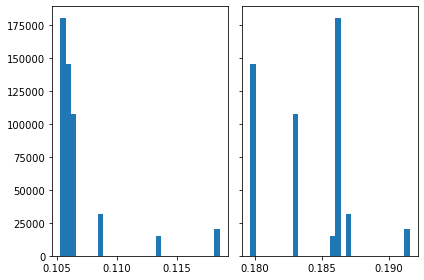

In [66]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(pdResult['mu'][RealStart:], bins=30)
axs[1].hist(pdResult['sigma'][RealStart:], bins=30)

In [67]:
estimatedParam = pdResult[RealStart:].mean(axis=0)

In [68]:
print('Estimation of mu differs from the real value by {0} % '
      .format((mu-estimatedParam["mu"])/mu*100))

Estimation of mu differs from the real value by -0.7049989582275331 % 


In [69]:
print('Estimation of sigma differs from the real value by {0} % '
      .format((sigma-estimatedParam["sigma"])/sigma*100))

Estimation of sigma differs from the real value by -1.5777176379322104 % 
